# 지능형 물체 탐지 카메라
지능형 물체 탐지 카메라를 만들어 보자. 구체적으로 이 프로젝트는 객체 탐지 모델을 활용하여 **해당 물체가 무엇이고, 몇 개 있는지를 사용자에게 명확하게 시각화하여** 윤택한 삶이 가능하도록 한다. 예를 들어, 냉장고에 음식이 무엇이 있는지, 그 음식이 몇 개 있는지 사용자에게 알려주는 모델을 본 코드로 구현할 수 있으며 이는 사용자 측면에서 매우 유익한 데이터일 것이다.

In [1]:
import pandas as pd
import numpy as np

from typing import Tuple, List, Dict, Any, Type
from copy import deepcopy

실습파일 (yolo_exam.zip) 을 압축 해제(unzip) 합니다.

In [3]:
!wget https://www.dropbox.com/scl/fi/oco115vwgatdded392ito/yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs&st=y0oj40tu&dl=0
!unzip yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs
!mv ./yolov3/* ./

--2024-09-09 12:50:45--  https://www.dropbox.com/scl/fi/oco115vwgatdded392ito/yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca36f3bd7d3402ff4930bf461e5.dl.dropboxusercontent.com/cd/0/inline/CaOtci3r-XeaZvhKLxczASZkGp4hdoJm5cUhZXji6RuSYiuOj2zytYhZVmesxRMQ90yOx7gGD0eM4i-1zGLKaVchu9eScNme9Xee03kv_W4obEc8RIw0y81MnEzitGMXoWXFD_-gvWLX-u0NBjsSaUpv/file# [following]
--2024-09-09 12:50:46--  https://uca36f3bd7d3402ff4930bf461e5.dl.dropboxusercontent.com/cd/0/inline/CaOtci3r-XeaZvhKLxczASZkGp4hdoJm5cUhZXji6RuSYiuOj2zytYhZVmesxRMQ90yOx7gGD0eM4i-1zGLKaVchu9eScNme9Xee03kv_W4obEc8RIw0y81MnEzitGMXoWXFD_-gvWLX-u0NBjsSaUpv/file
Resolving uca36f3bd7d3402ff4930bf461e5.dl.dropboxusercontent.com (uca36f3bd7d3402ff4930bf461e5.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100

In [ ]:
!ls

 config   dataset   docker   requirements   train.py   yolov3
 data	  demo.py   models   sample_data    utils     'yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs'


In [4]:
import argparse
import yaml
import os
import random

import cv2
import numpy as np
import torch
import torchvision
import torch.optim as optim
from torch.autograd import Variable

from models.yolov3 import *
from utils.utils import *
from utils.cocoapi_evaluator import COCOAPIEvaluator
from dataset.cocodataset import *
from __future__ import division

from utils.parse_yolo_weights import parse_yolo_weights

from utils.vis_bbox import vis_bbox
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
cfg_path = 'config/yolov3_default.cfg'
weights_path_train =  'darknet53.conv.74'
n_cpu =  0
checkpoint_interval =  1000
eval_interval =  4000
use_cuda = True
weights_path =  'yolov3.weights'
image = 'data/innsbruck.png'
detect_thresh = 0.5

### **Q1. 주어진 이미지를 불러오고 1) 이미지의 shape가 (1080, 810, 3) 임을 확인하시오. 2) shape을 (3, 1080, 810) 로 변경하시오. **

*   1) 번 문제는 이미지의 shape을 출력하여야 함.
*   2) 번 문제는 변경된 이미지의 shape을 출력하여야 함.

<div style="background-color:#E3F5FF;padding:10px">
    <li><b>출제의도</b>: 이미지 데이터 입력 및 전처리가 가능한지 확인하고자함. </li>
    <li><b>키워드</b>: 라이브러리 활용 능력 및 전처리 관련 능력 </li>
</div>

In [ ]:
! wget https://github.com/ultralytics/ultralytics/blob/main/ultralytics/assets/bus.jpg?raw=true
! mv bus.jpg?raw=true bus.jpg

--2024-09-09 09:54:55--  https://github.com/ultralytics/ultralytics/blob/main/ultralytics/assets/bus.jpg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ultralytics/ultralytics/raw/main/ultralytics/assets/bus.jpg [following]
--2024-09-09 09:54:55--  https://github.com/ultralytics/ultralytics/raw/main/ultralytics/assets/bus.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/assets/bus.jpg [following]
--2024-09-09 09:54:55--  https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/assets/bus.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

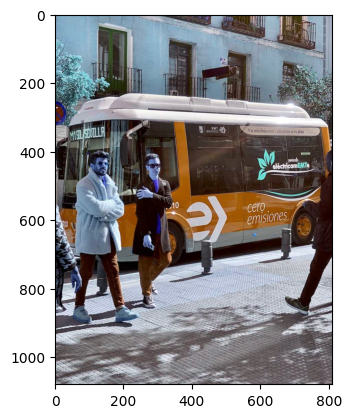

In [ ]:
img = cv2.imread('bus.jpg')
plt.imshow(img)

In [ ]:
# Sol
sh1 = img.shape
print(sh1) # (1080, 810, 3)

(1080, 810, 3)


### 2) shape을 (3, 1080, 810) 로 변경하세요. 단, 아래 코드를 변형하지 않고 빈칸을 채우세요.
* 이미지의 shape을 `sh2` 변수에 저장하고 이를 출력하시오.

In [ ]:
sh2 = img.transpose((2,0,1)).shape
print(sh2)

(3, 1080, 810)


### **Q2. IoU와 NMS를 구현합니다. 문제에 언급된 빈 코드를 완성하세요.**

![IoU0](https://gaussian37.github.io/assets/img/math/algorithm/iou/4.png)
![IOU](https://gaussian37.github.io/assets/img/math/algorithm/iou/5.png)

Intersection over Union (IoU)는 두 가지 물체의 위치가 얼마나 일치하는지에 대한 지표로, (Area of Intersection) / (Area of Union) 으로 계산할 수 있습니다.

![NMS](https://miro.medium.com/max/1200/1*6d_D0ySg-kOvfrzIRwHIiA.png)

NMS의 동작 과정은 아래와 같습니다.

1. 주어진 Box들 중 가장 높은 Confidence Score를 가진 Box를 선택한다.
2. 선택된 Box와 나머지 Box들간의 IoU (Interaction of Union)을 계산하고 특정값(NMS threshold) 이상이면 제거한다. (동일한 Object에 대한 Detection이기 때문에 겹치는 부분이 많을 것이라는 생각)
3. 특정한 Box의 숫자가 남을 때까지나 더이상 선택할 Box가 없을 때까지 위의 과정을 반복한다.

*   1) 번 문제는 IoU 알고리즘의 빈 칸을 채워서 구현해야 함.
*   2) 번 문제는 NMS 알고리즘의 빈 칸을 채워서 구현해야 함.

<div style="background-color:#E3F5FF;padding:10px">
    <li><b>출제의도</b>: IoU 및 NMS 알고리즘을 이해하며 간단한 파트에 대한 구현을 할 수 있음. </li>
    <li><b>키워드</b>: 알고리즘 구현 능력 </li>
</div>

### 아래 코드를 먼저 실행합니다.

In [ ]:
# preprocess(): img를 padding을 통해 정사각형으로 만든다 (utils/utils.py)
img, info_img = preprocess(img, imgsize=416, jitter=0)  # info = (h, w, nh, nw, dx, dy)
img = np.transpose(img / 255., (2, 0, 1))
img = torch.from_numpy(img).float().unsqueeze(0)
img = img.type(torch.FloatTensor)
print(img.shape, img.type)

torch.Size([1, 3, 416, 416]) <built-in method type of Tensor object at 0x7eefb8685b70>


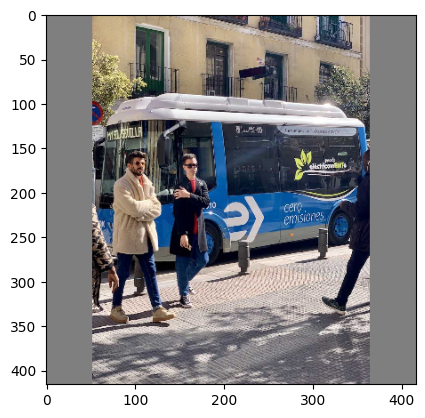

In [ ]:
plt.imshow(img[0].permute(1,2,0))

### 1) 제시된 IoU 코드의 일부분을 구현하시오. 즉, `b1_area`, `b2_area`, `intersection` 변수를 활용하여 IoU를 계산하는 코드를 제작하시오.



In [ ]:
def bboxes_iou(box1, box2):
    """
        Calculate the Intersection of Unions (IoUs) between bounding boxes.

        Input:
            box1 : Bounding Box1의 좌표값, np.array 형태의 [x1, y1, x2, y2]
            box2 : Bounding Box2의 좌표값, np.array 형태의 [x1, y1, x2, y2]
    """
    # 직사각형 box1, box2 의 넓이를 구한다.
    b1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    b2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 겹치는 box의 x좌표, y좌표의 최소 최대값을 구한다.
    x_i_min = max(box1[0], box2[0])
    x_i_max = min(box1[2], box2[2])
    y_i_min = max(box1[1], box2[1])
    y_i_max = min(box1[3], box2[3])

    # 위 그림에 설명된 원리에 따라, 교집합 영역의 좌표를 구한다.
    w = max(0, x_i_max - x_i_min)
    h = max(0, y_i_max - y_i_min)
    intersection = w * h
    ########################## SOL ##########################
    iou = intersection / (b1_area + b2_area - intersection)
    ########################## SOL ##########################

    return iou

### 2) NMS (Non-Maximum Suppression) 코드의 일부분을 구현하시오. 즉, IoU가 threshold **미만인** output은 True로 설정하는 코드를 구현하시오. (selec의 기본값은 False로 구성되어 있음.)


*   조건1: `all()` 을 사용한다.
*   조건2: `selec` 리스트의 인덱스로 `i`를 사용한다. 즉, `selec[i] = True` 와 같이 True 값을 입력한다.



In [ ]:
def nms(bbox, thresh, score=None):
    """
        Input:
            bbox : Bounding Box들의 좌표값, np.array 형태 (e.g., [[x1, y1, x2, y2], [x1, y1, x2, y2], [x1, y1, x2, y2]])
                   array([[199.66446, 243.73654, 234.61401, 272.00906],
                          [199.67168, 244.4378 , 231.70439, 271.90186],
                          [202.07721, 242.86081, 233.41031, 267.57233]]
            thresh : IoU의 Threshold 값
            score : 각 Bounding Box의 Confidence Score 값
    """

    # Bounding Box가 비어있는지 확인
    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    # Score가 큰 순서대로 정렬
    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]
    bbox_area = np.prod(bbox[:, 2:] - bbox[:, :2], axis=1)


    # 최종 선택된 Bounding Box를 표시하는 output (e.g., selec = [True, False, True])
    # True : 남아있는 Bounding Box / False : 남아있지 않은 Bounding Box
    selec = np.zeros(bbox.shape[0], dtype=bool)
    # [False, False, False]

    # Bounding Box 끼리의 IoU를 계산하고, IoU가 threshold 이상인 output은 False로 변경
    for i, b in enumerate(bbox):
        # b = [x1, y1, x2, y2]
        bl = np.maximum(b[:2], bbox[selec, :2])
        tr = np.minimum(b[2:], bbox[selec, 2:])
        area = np.prod(tr - bl, axis=1) * (bl < tr).all(axis=1)  # bl should be smaller than tr

        iou = area / (bbox_area[i] + bbox_area[selec] - area)

        # IoU가 threshold 이상인 output은 False로 / threshold 미만인 output은 True로 설정
        ###################### SOL #############################
        if (iou < thresh).all():
          selec[i] = True
        ###################### SOL #############################

    selec = np.where(selec)[0]

    if score is not None:
        selec = order[selec]

    return selec.astype(np.int32)

### 1) 번 문제와 2) 번 문제를 잘 작성했으면 아래 코드가 문제 없이 실행됩니다. 아래 코드가 문제 없이 실행되어야 정답 처리됩니다.

In [ ]:
box1 = np.array([199.66446, 243.73654, 234.61401, 272.00906])
box2 = np.array([199.67168, 244.4378,  231.70439, 271.90186])

s21 = bboxes_iou(box1, box2)
s21

0.8903326765956755

In [ ]:
before_nms = np.array([[209, 180, 284, 239],
                       [209, 175, 282, 242],
                       [212, 305, 251, 352],
                       [216, 301, 257, 349],
                       [214, 301, 258, 354]])
filtered_idx = nms(before_nms, thresh=0.5)
s22 = before_nms[filtered_idx]
s22

array([[209, 180, 284, 239],
       [212, 305, 251, 352]])

### 아래 코드를 다음 문제를 풀기 위해 실행하시오.

In [ ]:
import pdb
def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45):
  """
  YOLO 모델의 출력을 후처리하여 박스 좌표 변환, 신뢰도 임계값으로 필터링, 그리고 Non-maximum suppression을 수행합니다.

  Args:
      prediction (torch.Tensor): 모델 예측값으로, 형태는 (N, B, 4 + num_classes + 1)입니다.
          N: 배치의 이미지 수.
          B: 이미지당 박스 수.
          각 박스는 (xc, yc, w, h, conf, class_scores)로 구성됩니다.
      num_classes (int): 데이터셋의 클래스 수.
      conf_thre (float): 예측값을 필터링하는 신뢰도 임계값.
      nms_thre (float): 비최대 억제(NMS)에서 사용하는 IoU 임계값.

  Returns:
      List[torch.Tensor]: 배치의 각 이미지에 대한 후처리된 검출 결과.
  """
  # (xc, yc, w, h)를 (x1, y1, x2, y2)로 변환
  # box_corner.shape: (N, B, 4)
  box_corner = prediction.new(prediction.shape)
  box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
  box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
  box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
  box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
  prediction[:, :, :4] = box_corner[:, :, :4]

  # 결과를 저장할 출력 리스트 초기화
  # output: 길이가 N인 리스트, 각 요소는 None으로 초기화됨
  output = [None for _ in range(len(prediction))]

  # Process each image in the batch
  for i, image_pred in enumerate(prediction):
    # Find class with highest confidence for each box
      # 각 박스에 대해 최고 신뢰도의 클래스를 찾음
      # class_pred.shape: (B,)
      class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1)
      class_pred = class_pred[0]

      # 낮은 신뢰도의 박스를 필터링하기 위한 마스크 생성
      # conf_mask.shape: (B,), image_pred.shape: (B, 4+num_classes + 1)
      conf_mask = (image_pred[:, 4] * class_pred >= conf_thre).squeeze()
      image_pred = image_pred[conf_mask]

      if not image_pred.size(0):
          continue

      # ind.shape: (M, 2)
      ind = (image_pred[:, 5:] * image_pred[:, 4][:, None] >= conf_thre).nonzero()
    #   tensor([[ 0,  5],
    #     [ 1,  5],
    #     [ 2,  0],
    # (...)
    #     [15,  0]], device='cuda:0')

      detections = torch.cat((
              image_pred[ind[:, 0], :5],
              image_pred[ind[:, 0], 5 + ind[:, 1]].unsqueeze(1),
              ind[:, 1].float().unsqueeze(1)
              ), 1)

      # 각 클래스에 대해 Non-Maximum Suppression (NMS) 수행
      # unique_labels.shape: (L,)
      unique_labels = detections[:, -1].cpu().unique()
      if prediction.is_cuda:
          unique_labels = unique_labels.cuda()

      for c in unique_labels:
          # 주어진 클래스에 대한 모든 detection 결과를 가져옴
          # detections_class.shape: (K, 7)
          detections_class = detections[detections[:, -1] == c]
          nms_in = detections_class.cpu().numpy()
          nms_out_index = nms(nms_in[:, :4], nms_thre, score=nms_in[:, 4] * nms_in[:, 5])
          detections_class = detections_class[nms_out_index]

          # Store or concatenate the results
          if output[i] is None:
              output[i] = detections_class
          else:
              output[i] = torch.cat((output[i], detections_class))

  return output

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2024-09-09 09:57:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  2.13MB/s    in 92s     

2024-09-09 09:59:29 (2.57 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-09-09 09:59:29--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  2.22MB/s    in 85s     

2024-09-09 10:02:47 (1.82 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)
model = YOLOv3(cfg['MODEL'])

print("loading yolo weights %s" % (weights_path))
parse_yolo_weights(model, weights_path) # Parse YOLO (darknet) pre-trained weights data onto the pytorch model (utils/parse_yolo_weights.py)

loading yolo weights yolov3.weights


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
model.eval()
model = model.cuda()
img = img.cuda()

with torch.no_grad():
    outputs = model(img)
    outputs_post = postprocess(outputs, 80, conf_thre=0.8, nms_thre=0.45)
if outputs_post[0] is None:
    print("No Objects Deteted!!")
    assert AssertionError

coco_class_names, coco_class_ids, coco_class_colors = get_coco_label_names()

print(outputs_post)

[tensor([[ 70.7490, 152.5994, 135.3737, 347.1057,   0.9997,   1.0000,   0.0000],
        [316.4759, 152.7397, 362.6382, 344.4249,   0.9984,   0.9999,   0.0000],
        [136.1623, 158.3256, 189.0462, 330.9901,   0.9970,   0.9999,   0.0000],
        [ 47.7434,  74.4820, 369.8368, 292.2893,   0.9975,   0.9949,   5.0000]],
       device='cuda:0')]


### **Q4. YOLOv3의 결과를 시각화하고, 그 시각화의 결과를 종합하여 pie chart로 표현하시오.**

*   1) 번 문제는 제시된 bboxes, classes, colors 리스트를 바탕으로 YOLOv3의 결과를 시각화하여야 함.
*   2) 번 문제는 YOLOv3의 Object Detection 결과를 활용하여 pie chart를 생성하여야 함.
*   아래 코드를 활용할 것.

In [ ]:
outputs_post = [[[ 70.8352, 152.6342, 135.7572, 346.3126,   0.9997,   1.0000,   0.0000], [316.9563, 152.3509, 362.6225, 344.4236,   0.9987,   0.9999,   0.0000], [136.1743, 159.0133, 188.1921, 331.0620,   0.9958,   0.9999,   0.0000], [ 51.8102, 223.5015,  78.6763, 334.8621,   0.6398,   0.9939,   0.0000], [ 48.7808,  75.9459, 370.6321, 291.8965,   0.9977,   0.9941,   5.0000]]]

5

<div style="background-color:#E3F5FF;padding:10px">
    <li><b>출제의도</b>: YOLOv3 알고리즘을 matplotlib을 활용하여 시각화할 수 있음. 또한 시각화된 사진 내부에 있는 정보를 바탕으로 pie chart를 제작할 수 있음. </li>
    <li><b>키워드</b>: 시각화 능력 및 라이브러리 활용 능력 </li>
</div>

### 1) bus.jpeg 파일을 바탕으로, YOLOv3의 결과를 시각화할 수 있도록 빈 칸을 채우시오.

예시:

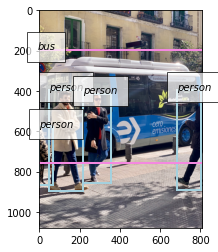

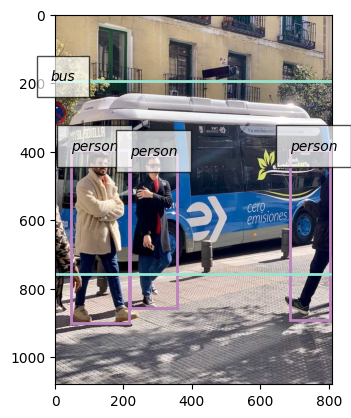

[192.1153846153846, -12.98076923076923, 758.0769230769231, 822.9807692307693]


In [82]:
# Sol

bboxes = list()
classes = list()
colors = list()
s41 = list()

for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs_post[0]:
    cls_id = coco_class_ids[int(cls_pred)]

    ############## SOL ##################
    box = yolobox2label([int(y1), int(x1), int(y2), int(x2)], info_img)
    ############## SOL ##################
    bboxes.append(box)
    s41.append(len(box))
    classes.append(cls_id)
    colors.append(coco_class_colors[int(cls_pred)])

img_raw = cv2.imread('bus.jpg')
img_raw[:,:,::-1].transpose((2,0,1)).shape
img_raw = img_raw.copy()[:, :, ::-1].transpose((2, 0, 1))

vis_bbox(img_raw, bboxes, label=classes, label_names=coco_class_names, instance_colors=colors, linewidth=2)
plt.show()

print(box)

### 2) 제작된 YOLOv3 결과를 바탕으로, YOLOv3이 어떠한 물체를 탐지하였는지, 그 물체는 몇 개가 있는지 한 눈에 보고자 합니다. 1) 번 문제에서 도출된 물체명과 그 수를 바탕으로 해당 결과를 pie chart로 표현하시오. 빈 칸을 채우시오.

*   Hint: Counter를 사용한다.
*   Counter 객체는 `keys()`, `values()` 메서드를 활용할 수 있다.
*   `key`, `value` 변수의 type은 list여야 한다.

예시:

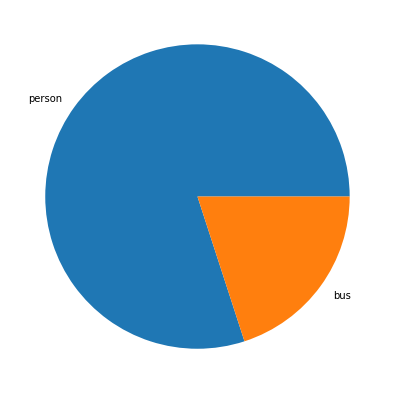

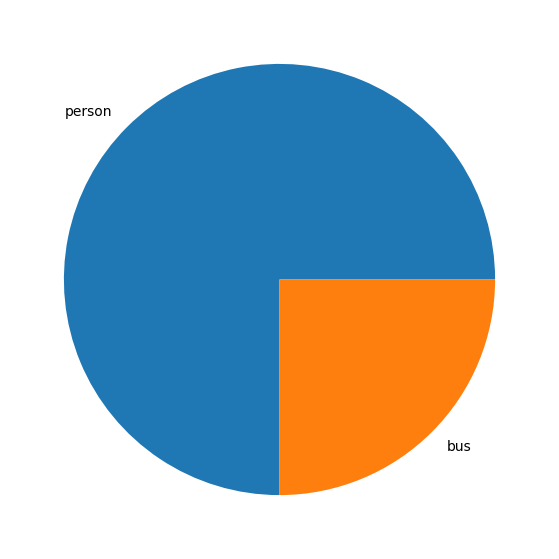

In [ ]:
# Sol

item = list()
for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs_post[0]:
    cls_id = coco_class_ids[int(cls_pred)]
    item.append(coco_class_names[cls_id])

cnt = Counter(item)
################ SOL ################
key = list(cnt.keys())
val = list(cnt.values())
#####################################

fig = plt.figure(figsize =(10, 7))
plt.pie(val, labels=key)
plt.show()

In [ ]:
print(key, val)

['person', 'bus'] [4, 1]


> 출력이 `['person', 'bus'] [4, 1]` 가 나오고, 위 plot이 시각화되어야 정답 처리됩니다.



### **Q5. 주어진 이미지 파일명을 입력으로 받아 YOLOv3 모델을 사용해 물체 탐지를 수행하고, 그 결과를 시각화하는 함수를 작성하시오.**
- 해당 함수는 입력 이미지에서 탐지된 물체의 바운딩 박스(bounding box)를 그려주는 동시에, 탐지된 물체의 클래스와 바운딩 박스를 튜플 형태로 반환해야 합니다.
- 탐지된 물체의 종류와 바운딩 박스를 이미지에 그려서 시각화합니다.

요구 사항:

- 탐지된 객체 시각화: 각 객체의 바운딩 박스를 이미지에 그립니다.
객체명 표시: 각 바운딩 박스의 중앙 또는 상단에 객체명을 텍스트로 표시합니다.
- 결과 반환: 함수는 탐지된 객체들의 바운딩 박스 좌표와 해당 클래스명을 튜플로 반환해야 합니다.
- 반환 형식: Tuple[List[Tuple[float, float, float, float]], List[str]]
- 바운딩 박스 좌표: 각 객체에 대한 (x1, y1, x2, y2) 형식의 리스트.
- 클래스명: 각 객체에 대한 클래스명 리스트.


In [104]:
def draw_detection(image_file: str, model, conf_thre=0.7):
    """
    주어진 이미지 파일에 대해 YOLOv3 모델을 사용해 물체 탐지를 수행하고,
    결과를 시각화하는 함수.

    Args:
        image_file (str): 입력 이미지의 파일 경로.
        model: 사전 학습된 YOLOv3 모델.
        conf_thre (float): 탐지를 위한 신뢰도 임계값. 기본값은 0.7.

    Returns:
        Tuple[List[Tuple[float, float, float, float]], List[str]]:
        - Bounding boxes: 탐지된 각 객체의 좌표 리스트 (x1, y1, x2, y2).
        - Classes: 탐지된 각 객체의 클래스 리스트.
    """
    # 1. 이미지 불러오기 및 전처리
    img_raw = cv2.imread(image_file)
    img, info_img = preprocess(img_raw, imgsize=416, jitter=0)  # 이미지 padding 및 크기 조정
    img = np.transpose(img / 255., (2, 0, 1))
    img = torch.from_numpy(img).float().unsqueeze(0)
    img = img.type(torch.FloatTensor)

    # 2. 모델 평가 모드 및 GPU로 전송
    model.eval()
    model = model.cuda()
    img = img.cuda()

    # 3. YOLO 모델 예측 수행
    with torch.no_grad():
        outputs = model(img)
        outputs_post = postprocess(outputs, 80, conf_thre=conf_thre, nms_thre=0.45)

    if outputs_post[0] is None:
        print("No Objects Detected!!")
        return [], []

    # 4. 탐지된 물체 정보 추출 및 저장
    bboxes = []
    classes = []
    colors = []

    for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs_post[0]:
        cls_id = coco_class_ids[int(cls_pred)]

        # 바운딩 박스 좌표 변환 (원본 이미지로 변환)
        box = yolobox2label([int(y1), int(x1), int(y2), int(x2)], info_img)
        bboxes.append(box)
        classes.append(cls_id)
        colors.append(coco_class_colors[int(cls_pred)])

    # 5. 시각화 (바운딩 박스 및 클래스명 표시)
    img_raw = cv2.imread(image_file)
    img_raw = img_raw.copy()[:, :, ::-1].transpose((2, 0, 1))

    vis_bbox(img_raw, bboxes, label=classes, label_names=coco_class_names, instance_colors=colors, linewidth=2)
    plt.show()

    # 6. 바운딩 박스 및 클래스 반환
    return bboxes, classes


새로운 jpg 파일을 다운받아 위의 코드를 검증합니다.

In [86]:
!gdown 1bYnW7jxewV3mxRo45K--1OYjjmA7taAg

Downloading...
From: https://drive.google.com/uc?id=1bYnW7jxewV3mxRo45K--1OYjjmA7taAg
To: /content/road.jpg
100% 205k/205k [00:00<00:00, 112MB/s]


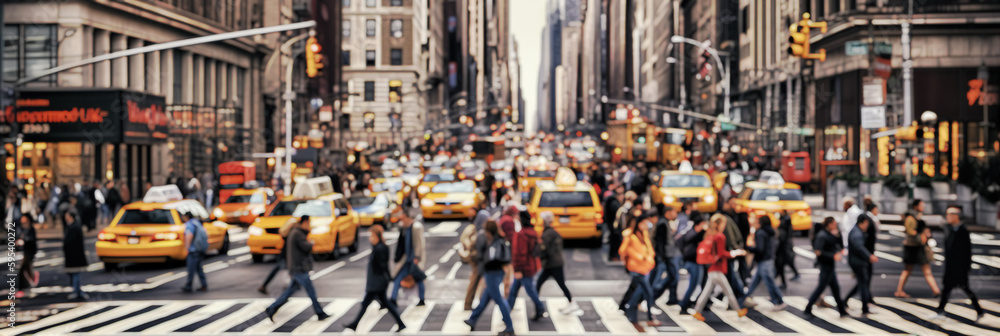

In [110]:
from PIL import Image

Image.open("road.jpg")

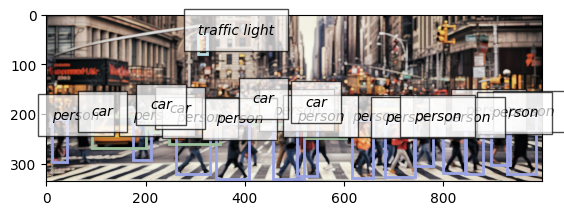

예측된 클래스:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 10]
예측된 박스들:  [[200.63309352517985, 843.75, 321.49640287769785, 879.8076923076923], [203.05035971223023, 927.8846153846155, 321.49640287769785, 987.9807692307693], [200.63309352517985, 456.7307692307692, 331.1654676258993, 519.2307692307693], [212.71942446043164, 615.3846153846155, 328.7482014388489, 658.6538461538462], [205.46762589928056, 896.6346153846155, 302.158273381295, 935.0961538461539], [210.30215827338128, 175.48076923076923, 292.48920863309354, 211.53846153846155], [215.13669064748203, 682.6923076923077, 326.33093525179856, 742.7884615384615], [210.30215827338128, 12.01923076923077, 297.32374100719426, 40.86538461538461], [212.71942446043164, 504.80769230769226, 323.9136690647482, 545.6730769230769], [215.13669064748203, 262.0192307692308, 321.49640287769785, 329.3269230769231], [217.55395683453236, 341.34615384615387, 331.1654676258993, 408.6538461538462], [215.13669064748203, 800.4807692307693, 319.079136690

In [106]:
bboxes, classes = draw_detection("road.jpg", model)
print("예측된 클래스: ", classes)
print("예측된 박스들: ", bboxes)

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


### **Q6. 실사 이미지가 아닌 다양한 형태의 이미지에 대해 Object detection을 진행해봅시다.**

- COCO, Pascal VOC와 같은 데이터셋은 실제 이미지에 대한 Object 정보를 예측하도록 설계되었습니다.

- 손그림, 애니메이션과 같은 형태의 이미지에 대해 YOLO v3 모델의 object detection 결과를 확인해봅시다.


In [9]:
!gdown 1c-Mcdpm3YaAuJzeqIxv8opcJzWWLe4US
!gdown 1Ds2NkD25mFUDs_3IEPxD6oP1MELi-53U

Downloading...
From: https://drive.google.com/uc?id=1c-Mcdpm3YaAuJzeqIxv8opcJzWWLe4US
To: /content/chopsticks.jpg
100% 310k/310k [00:00<00:00, 23.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ds2NkD25mFUDs_3IEPxD6oP1MELi-53U
To: /content/sponge.jpg
100% 71.1k/71.1k [00:00<00:00, 43.5MB/s]


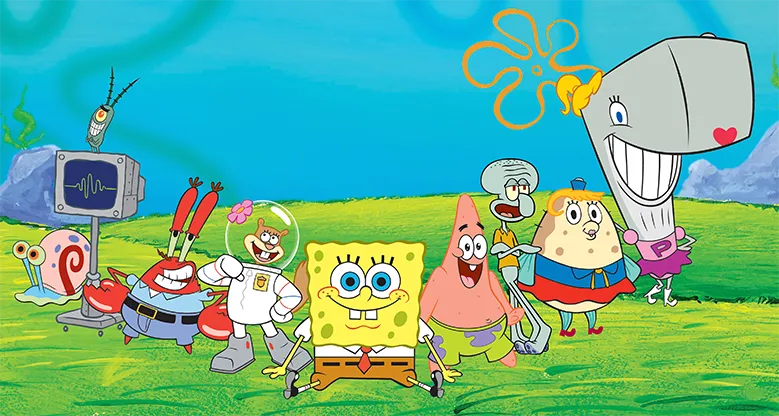

In [11]:
from PIL import Image

Image.open("sponge.jpg")

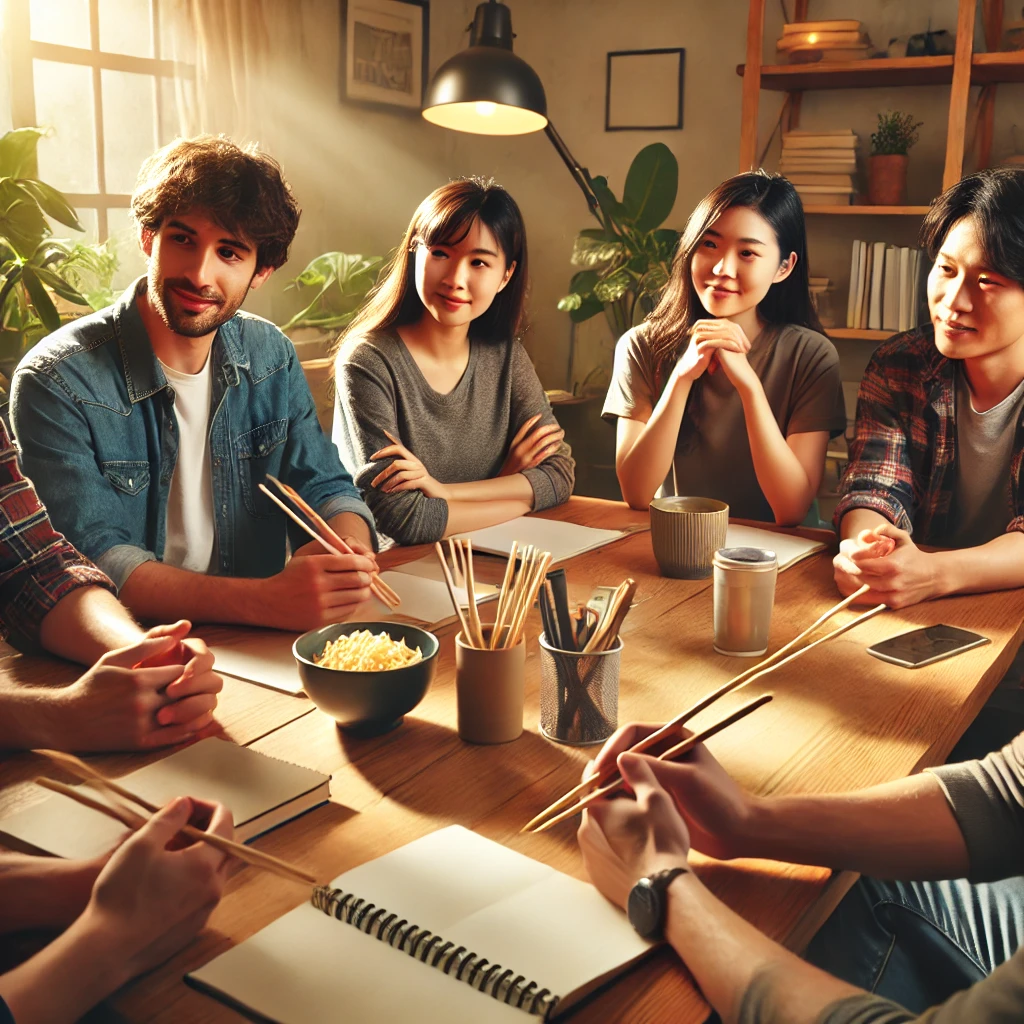

In [14]:
Image.open("chopsticks.jpg")